In [1]:
# Contrôle de version
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

# Packages nécessaires
import numpy as np
import os
import re
import matplotlib.pyplot as plt
# A la première utilisation de nltk, télécharger les données nécessaires
import nltk
#nltk.download('punkt')

[//]: # (<span style="color:red">TODO</span> pour signaler du contenu manquant)

##  Word Embeddings : Représentations distribuées via l'hypothèse distributionelle

**But**: On va chercher à obtenir des représentations denses (comme vecteurs de nombres réels) de mots (et éventuellement de phrases). Ces représentations ont vocation à être distribuées: ce sont des représentations non-locales. On représente un objet comme une combinaison de *features*, par opposition à l'attribution d'un symbole dédié: voir le travail fondateur d'entre autres, Geoffrey Hinton, sur le sujet: [Distributed Representations](https://web.stanford.edu/~jlmcc/papers/PDP/Chapter3.pdf).

Le terme de représentation *distribuées* est très général, mais correspond à que l'on cherche à obtenir. L'enjeu est donc de pouvoir construire, automatiquement, de telles représentations.

**Idée sous-jacente**: Elle est basée sur l'hypothèse distributionelle: les informations contextuelles suffisent à obtenir une représentation viable d'objets linguistiques.
 - *“For a large class of cases [...] the  meaning  of a word is  its  use in the  language.”* Wittgenstein (Philosophical Investigations, 43 - 1953)
 - *“You shall know a word by the company it keeps”*, Firth ("A synopsis of linguistic theory 1930-1955." - 1957)

Ainsi, on peut caractériser un mot par les mots qui l'accompagnent, via des comptes de co-occurences. Deux mots ayant un sens similaire auront une distribution contextuelle similaire et auront donc plus de chance d'apparaître dans des contextes similaires. Cette hypothèse peut servir de justification à l'application de statistiques à la sémantique (extraction d'information, analyse sémantique). Elle permet aussi une certaine forme de généralisation: on peut supposer que les informations que l'on a à propos d'un mot se généraliseront aux mots à la distribution similaire. 

**Motivation**: On cherche à obtenir des représentations distribuées pour pouvoir, de manière **efficace**:
- Directement réaliser une analyse sémantique de surface.
- S'en servir comme source d'informations pour d'autres modèles et applications liées au language, notamment pour l'analyse de sentiments. 


**Terminologie**: Attention à ne pas confondre l'idée de représentation *distribuée* et *distributionelle*. Le second indique en général (pour les mots) que la représentation a été obtenue strictement à partir de comptes de co-occurences, alors qu'on pourra utiliser des informations supplémentaires (labels de documents, tags de partie du discours, ...) pour construire des représentations distribuées. 
Les modèles qui permettent de construire ces représentations denses, sous forme de vecteurs, sont souvent appellés *vector spaces models*. On appelle aussi régulièrement ces représentations des *word embeddings*, car les mots sont embarqués (*embedded*) dans un espace vectoriel. En Français, on rencontre souvent le terme *plongements de mots* ou *plongements lexicaux*.

## Obtenir une représentation: comptes d'occurences et de co-occurences

Selon le type de corpus dont on dispose, on pourra obtenir différents types d'informations distributionelles. Si l'on a accès à une collection de documents, on pourra ainsi choisir de compter le nombre d'occurence de chaque mot dans chacun des documents, pour obtenir une matrice $mots \times documents$: c'est sur ce principe qu'est construit **Tf-Idf** (vu au TP précédent). On va maintenant s'intéresser à un cas plus général: on dispose d'une grande quantité de données sous forme de texte, et on cherche à obtenir des représentations de mots sous forme de vecteurs de taille réduite, sans avoir besoin d'un découpage en documents ou catégories. 

Supposons qu'on dispose d'un corpus contenant $T$ mots différents. On va construire une matrice $\mathbf{M}$ de taille $T \times T$ qui contiendra le nombre de co-occurences entre les mots. Il y aura différents facteurs à considérer lors de la construction de cette matrice: 
- Comment définir le 'contexte' d'un mot, qui permettra de dire que les termes qu'il contient co-occurent avec ce mot ? On pourra choisir d'utiliser différentes échelles: le document, la phrase, le groupe nominal, ou tout simplement une fenêtre de $k$ mots, selon les informations que l'on cherche à capturer.
*Encore une fois, si par exemple notre corpus est divisé en $D$ documents, on pourra même s'intéresser aux liens distributionnels entre mots et documents: chacun de ces $D$ documents agira comme un "contexte", et on construit une matrice d'occurences $\mathbf{M}$ de dimension $T \times D$, où $\mathbf{M}_{t,d}$ contient le nombre d'occurences du mot $t$ dans le document $d$.* 
- Comment quantifier l'importance des comptes ? Par exemple, on pourra donner un poids décroissant à une co-occurence selon la distance entre les deux mots concernés ($\frac{1}{d+1}$ pour une séparation par $d$ mots).
- Faut-il garder tous les mots qui apparaissent dans le corpus ? En général, non. On verra que pour les grands corpus, le nombre de mots différents $T$ est énorme. Deuxièmement, même si le nombre de mots est raisonnable, on ne possèdera que très peu d'information distributionelle sur les mots les plus rares, et la représentation obtenue sera à priori de mauvaise qualité. Il faudra se poser la question de comment filtrer ces mots, et de comment traiter les mots qu'on choisit de ne pas représenter.  

#### Procédure

Pour construire la matrice, on va dans un premier temps recueillir la liste des mots différents (ou le *vocabulaire* $V$) qui apparaissent dans le corpus sous forme de dictionaire {mots -> index}
Puis, pour chaque terme $w$ du corpus,
- On récupère l'index $i$ correspondant à l'aide de $V$
- Pour chaque terme $w'$ du contexte de $w$, 
  + On récupère l'index $j$ correspondant à l'aide de $V$
  + On incrémente $\mathbf{M}_{i,j}$ par le poids correspondant, ou par $1$. 
  
La procédure est très proche de celle qu'on a suivi au TP précédent, excepté qu'il faut maintenant compter les mots suivant leur apparition 
  
#### Exemple

On considère le corpus suivant: 

*I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue.*

On choisit de définir le contexte d'un mot comme la phrase à laquelle il appartient, et de ne pas utiliser de poids. 
On obtient la matrice suivante: 

|     *         | I | the | down | walked | boulevard | avenue | walk | ran | city |
|---------------|---|-----|------|--------|-----------|--------|------|-----|------|
| I             | 0 |      6 |    6 |   2 |         2 |      2 |   2 |    1 |    1 |
| the           | 6 |      2 |    7 |   2 |         2 |      3 |   3 |    1 |    1 |
| down          | 6 |      7 |    2 |   3 |         3 |      2 |   2 |    1 |    1 |
| walked        | 2 |      2 |    3 |   0 |         1 |      1 |   0 |    0 |    0 |
| boulevard     | 2 |      2 |    3 |   1 |         0 |      0 |   0 |    1 |    0 |
| avenue        | 2 |      3 |    2 |   1 |         0 |      0 |   1 |    0 |    0 |
| ran           | 2 |      3 |    2 |   0 |         0 |      1 |   0 |    0 |    1 |
| walk          | 1 |      1 |    1 |   0 |         1 |      0 |   0 |    0 |    0 |
| city          | 1 |      1 |    1 |   0 |         0 |      0 |   1 |    0 |    1 |

In [2]:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)
    
    tokens = text.split()        
    return tokens

### Obtenir un Vocabulaire:

Cette fois, on va implémenter séparément une fonction retournant le vocabulaire. Il faudra ici pouvoir contrôler sa taille, que ce soit en indiquant un nombre maximum de mots, ou un nombre minimum d'occurences pour qu'on prenne en compte les mots. On ajoute, à la fin, un mot "inconnu" qui remplacera tous les mots qui n'apparaissent pas dans notre vocabulaire 'limité'. 

In [3]:
def vocabulary(corpus, count_threshold=0, voc_threshold=10000):
    """    
    Function using word counts to build a vocabulary
    Params:
        corpus (list of list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary - 0 (default) indicates there is no max
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency 
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: word counts in the corpus
    """
    word_counts = {}
    #
    # A compléter ! 
    #   
    for sentence in corpus :
        for word in sentence.split():
            if word in word_counts :
                word_counts[word] += 1
            else :
                word_counts[word] = 1
        
    word_counts = sorted(word_counts.items(), key=lambda t: -t[1])

    filtered_word_counts = {} 
    #
    # A compléter ! 
    #   
    if voc_threshold == 0:
        voc_threshold = 100000000
        
    i = 0
    for cle,valeur in word_counts:
        if valeur >= count_threshold and i < voc_threshold :
            filtered_word_counts[cle] = valeur
            i += 1
        else : 
            break
            
    if not 'UNK' in filtered_word_counts :
        filtered_word_counts['UNK'] = 0
        
    vocabulary = {}
    vocabulary_word_counts = filtered_word_counts
    #
    # A compléter ! 
    #
    i = 0
    for cle,valeur in vocabulary_word_counts.items():
        vocabulary[cle] = i
        i +=1
    return vocabulary, vocabulary_word_counts

In [4]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'I': 2, 'UNK': 3}
{'down': 6, 'the': 6, 'I': 5, 'UNK': 0}
{'down': 0, 'the': 1, 'I': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
{'down': 6, 'the': 6, 'I': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}


### Obtenir les co-occurences:

La fonction prend en entrée le corpus (une liste de strings, correspondant aux documents, ou phrases) et un vocabulaire, ainsi que la taille de la fenêtre de contexte. On pourra aussi implémenter la solution la plus simple - que le contexte d'un mot soit le reste du document duquel il provient. 
Enfin, on pourra implémenter la possibilité de faire décroitre linéairement l'importance d'un mot du contexte à mesure qu'on s'éloigne du mot d'origine. 

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Obtenir la phrase:
        sent = nltk.word_tokenize(sent)
        # Obtenir les indexs de la phrase grace au vocabulaire: 
        sent_idx = [vocabulary.get(word, len(vocabulary) - 1) for word in sent] # a compléter
        # Parcourir les indexs de la phrase et ajouter 1 / dist(i,j) à M[i,j] si les mots d'index i et j apparaissent dans la même fenêtre. 
        for i, idx_i in enumerate(sent_idx):
            # On vérifie que le mot est reconnu par le vocabulaire:
            if idx_i > -1:
                # Si on considère un contexte limité:
                if window > 0:
                    # On crée une liste qui contient les indexs de la fenêtre à gauche de l'index courant 'idx_i'
                    l_ctx_idx = [sent_idx[j] for j in range(max(0, i-window), i)]
                    # A compléter
                # Si on considère que le contexte est la phrase entière:
                else:
                    # La liste qui contient le contexte à gauche du mot est plus facile à créer:
                    l_ctx_idx = sent_idx[:i]
                    # A compléter
                # On parcourt cette liste et on update M[i,j]:    
                for j, idx_j in enumerate(l_ctx_idx):
                    # ... en s'assurant que le mot correspondant à 'idx_j' est reconnu par le vocabulaire
                    if idx_j > -1:
                        # Calcul du poids:
                        if distance_weighting:
                            weight = 1.0 / (len(l_ctx_idx) - j)
                            # A compléter 
                        else:
                            weight = 1.0
                        M[idx_i, idx_j] += weight * 1.0
                        M[idx_j, idx_i] += weight * 1.0
    return M  

In [7]:
print(co_occurence_matrix(corpus, voc, 0, False))

[[2. 7. 6. 3. 3. 2. 2. 1. 1. 0.]
 [7. 2. 6. 2. 2. 3. 3. 1. 1. 0.]
 [6. 6. 0. 2. 2. 2. 2. 1. 1. 0.]
 [3. 2. 2. 0. 1. 1. 0. 0. 0. 0.]
 [3. 2. 2. 1. 0. 0. 0. 1. 0. 0.]
 [2. 3. 2. 1. 0. 0. 1. 0. 0. 0.]
 [2. 3. 2. 0. 0. 1. 0. 0. 1. 0.]
 [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


#### Application à un vrai jeu de données

On va chercher à obtenir ces comptes pour les données **imdb**:

In [36]:
from glob import glob
filenames_neg = sorted(glob(os.path.join('.', 'data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(os.path.join('.', 'data', 'imdb1', 'pos', '*.txt')))

texts_neg = [open(f, encoding="utf8").read() for f in filenames_neg]
texts_pos = [open(f, encoding="utf8").read() for f in filenames_pos]
texts = texts_neg + texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
y = np.ones(len(texts), dtype=np.int)
y[:len(texts_neg)] = 0.

print("%d documents" % len(texts))

25000 documents


#### Etude rapide des données

On voudrait ici, avant de procéder, avoir une idée de ce que contiennent ces critiques de films. On va donc obtenir le vocabulaire (entier) et représenter les fréquences des mots, dans l'ordre (attention, il faudra utiliser une échelle logarithmique): on devrait retrouver la loi de Zipf. Cela nous permettra d'avoir une idée de la taille du vocabulaire qu'on pourra choisir : il s'agit de réaliser un compromis entre les ressources nécessaires (taille des objets en mémoire) et quantité d'informations qu'on peut en tirer (les mots rares peuvent apporter beaucoup d'informations, mais il est difficile d'en apprendre de bonnes représentations,car ils sont rares !)  

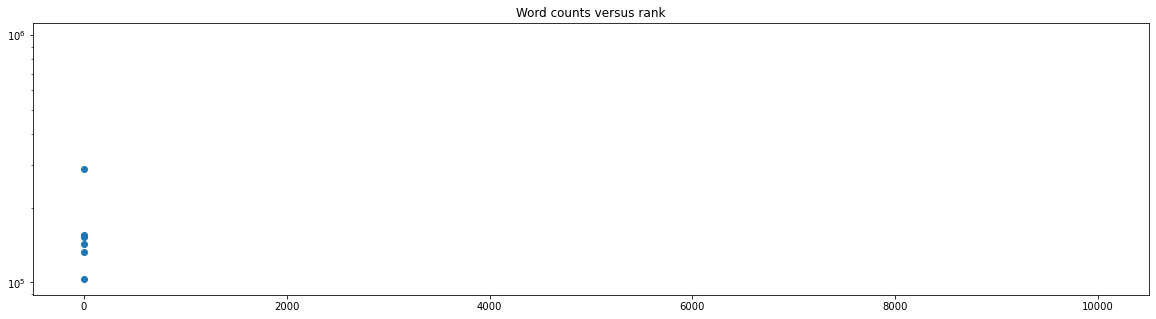

Vocabulary size: 10001
Part of the corpus by taking the "x" most frequent words ?
5000 : 0.94
10000 : 1.00


In [38]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
corpus = texts

vocab, word_counts = vocabulary(corpus)
rank_counts = {w:[vocab[w], word_counts[w]] for w in vocab}
rank_counts_array = np.array(list(rank_counts.values()))

# We can for example use the function plt.scatter()
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(rank_counts_array[:,0], rank_counts_array[:,1])
plt.yscale('log')
plt.show()

# We would like to know how much of the data is represented by the 'k' most frequent words
print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words ?')
for i in range(5000, len(vocab), 5000):
    print('%i : %.2f' % (i, np.sum(rank_counts_array[:i, 1]) / np.sum(rank_counts_array[:,1]) ))


Résultat de l'analyse: on peut se contenter d'un vocabulaire de 10000, voire 5000 mots - c'est important, car cela va déterminer la taille des objets que l'on va manipuler. On va maintenant recréer la matrice de co-occurence avec différents paramètres. Cela peut-être long: si cela pose problème, travaillez avec un vocabulaire plus réduit.

In [39]:
vocab_5k, word_counts_5k = vocabulary(corpus, 0, 5000)
M5dist = co_occurence_matrix(corpus, vocab_5k, window=5, distance_weighting=True)
M20 = co_occurence_matrix(corpus, vocab_5k, window=20, distance_weighting=False)
print(M5dist.shape)
print(M20.shape)

(5001, 5001)
(5001, 5001)


In [40]:
print(vocab_5k['cinema'])
print(M5dist[429])
print(M20[429])

719
[467.23333333 148.86666667 233.48333333 ...   0.           0.
 845.55      ]
[2.6300e+03 1.4900e+03 1.6200e+03 ... 1.0000e+00 0.0000e+00 1.0627e+04]


### Comparaison de vecteurs

On peut se servir de ces vecteurs de très grande taille pour une analyse sémantique très basique: par exemple, en cherchant les plus proches voisins d'un mot. Cependant, il faudra faire attention aux distances qu'on utilise, liées à certaines métriques (Euclidiennes, Cosine) ou éventuellement d'autres liées à l'appartenance aux ensembles (Matching, Jaccard). La normalisation des vecteurs peut aussi jouer un rôle. Dans tous les cas, il faut bien faire attention à ne pas sur-interprêter ce type de résultats. 

In [41]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))

from sklearn.neighbors import NearestNeighbors

def print_neighbors(distance, voc, co_oc, mot, k=10):
    inv_voc = {id: w for w, id in voc.items()}
    neigh = NearestNeighbors(k, algorithm='brute', metric=distance)
    neigh.fit(co_oc) 
    dist, ind = neigh.kneighbors([co_oc[voc[mot]]])
    print("Plus proches voisins de %s selon la distance '%s': " % (mot, distance.__name__))
    print([[inv_voc[i] for i in s[1:]] for s in ind])
    
print("Avec un contexte large, sans prendre en compte la distance entre les mots:")    
print_neighbors(euclidean, vocab_5k, M20, 'good')
print_neighbors(cosine, vocab_5k, M20, 'good')
print("")
print("Avec un contexte plus petit, et en réduisant l'impact des paires de mots selon leur distance:")    
print_neighbors(euclidean, vocab_5k, M5dist, 'good')
print_neighbors(cosine, vocab_5k, M5dist, 'good') 

Avec un contexte large, sans prendre en compte la distance entre les mots:


C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Plus proches voisins de good selon la distance 'euclidean': 
[['very', 'This', 'more', 'there', 'up', 'what', 'would', 'which', 'some']]


C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Plus proches voisins de good selon la distance 'cosine': 
[['great', 'very', 'decent', 'pretty', 'nice', 'cool', 'not', 'bad', 'quite']]

Avec un contexte plus petit, et en réduisant l'impact des paires de mots selon leur distance:


C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Plus proches voisins de good selon la distance 'euclidean': 
[['very', 'great', 'bad', 'really', 'even', 'also', 'there', 'she', 'had']]


C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Plus proches voisins de good selon la distance 'cosine': 
[['great', 'fine', 'wonderful', 'strong', 'strange', 'nice', 'solid', 'simple', 'decent']]


### Méthodes de pondération des matrices

**Motivation**: On ne se base pour l'instant que sur la fréquence (ou au mieux, une pondération de la fréquence) pour construire ces représentations. Comme on peut s'en douter, la fréquence seule n'est pas suffisante pour capturer des informations sémantiques intéressantes. On peut l'illustrer avec le phénomène des mots très fréquents qui apparaissent dans de nombreux contextes très différents, ou de mots qui apparaissent très souvent ensemble sans avoir nécessairement de lien sémantique.

**Normalisation**: Très simple; il s'agit d'annuler l'influence de la magnitude des comptes sur la représentation.

$$\mathbf{m_{normalized}} = \left[ 
   \frac{m_{1}}{\sum_{i=1}^{n}m_{i}}, 
   \frac{m_{2}}{\sum_{i=1}^{n}m_{i}}, 
   \ldots
   \frac{m_{n}}{\sum_{i=1}^{n}m_{i}}, 
\right]$$
 
**Pointwise Mutual Information**: Il s'agit d'évaluer à quel point la co-occurence des deux termes est *inattendue*. En effet, cette mesure correspond au ratio de la probabilité jointe des deux mots et du produit de leur probabilités individuelles:
$$
\text{PMI}(x,y) = \log \left( \frac{P(x,y)}{P(x)P(y)} \right)
$$
La probabilité jointe des deux mots correspond au nombre de fois ou on les observe ensemble, divisé par le nombre total de co-occurences du corpus: 
$$ P(\mathbf{M},w_{1},w_{2}) = \frac{M_{w_{1},w_{2}}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
La probabilité individuelle d'un mot correspond simplement à sa fréquence, que l'on peut calculer en comptant toutes les co-occurences ou ce mot apparaît:
$$ P(\mathbf{M},w) = \frac{\sum_{j=1}^{m} M_{w,j}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
Ainsi,
$$ 
\text{PMI}(\mathbf{M},w_{1},w_{2}) = \log  \frac{M_{w_{1},w_{2}} \times \left( \sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j} \right)}{\left( \sum_{j=1}^{n} M_{w_{1},j} \right) \times \left( \sum_{i=1}^{n}M_{i,w_{2}} \right)} 
$$
On calcule ainsi le décalage entre l'observation que l'on a fait dans notre corpus et la fréquence d'apparition de ces termes si on les considère indépendant - c'est à dire qu'on suppose que leur co-occurence est une coïncidence.

Le principal problème avec cette mesure est qu'elle n'est pas adaptée au cas où l'on observe aucune co-occurence. Puisque la PMI est censée renvoyer une quantité positive si l'on observe plus de co-occurences que prévu, et négative si l'on en observe moins, on ne peut pas choisir de remplacer $\log(0)$ par $0$. Une solution couramment utilisée est d'utiliser la **Positive PMI**, qui fixe toutes les valeurs négatives à $0$.
 
 $$\text{PPMI}(\mathbf{M},w_{1},w_{2}) = 
 \begin{cases}
 \text{PMI}(\mathbf{M},w_{1},w_{2}) & \textrm{if } \text{PMI}(\mathbf{M},w_{1},w_{2}) > 0 \\
 0 & \textrm{otherwise}
 \end{cases}$$

In [42]:
def pmi(co_oc, positive=True):
    sum_vec = co_oc.sum(axis=0)
    sum_tot = sum_vec.sum()
    with np.errstate(divide='ignore'):
        pmi = np.log((co_oc * sum_tot) / (np.outer(sum_vec, sum_vec)))                   
    pmi[np.isinf(pmi)] = 0.0  # log(0) = 0
    if positive:
        pmi[pmi < 0] = 0.0
    return pmi

In [43]:
PPMI5 = pmi(M5dist)
PPMI20 = pmi(M20)

print("Avec la PPMI:")    
print_neighbors(euclidean, vocab_5k, PPMI5, 'good')
print_neighbors(cosine, vocab_5k, PPMI5, 'good')
print_neighbors(euclidean, vocab_5k, PPMI20, 'good')
print_neighbors(cosine, vocab_5k, PPMI20, 'good')

C:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Avec la PPMI:


C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**TF-IDF**: Comme on l'a déjà vu, il s'agit du produit de la fréquence du terme (TF) et de sa fréquence inverse dans les documents (IDF). 
Cette méthode est habituellement utilisée pour extraire l'importance d'un terme $i$ dans un document $j$ relativement au reste du corpus, à partir d'une matrice $termes \times documents$. Ainsi, pour une matrice $\mathbf{X}$ de $n$ termes et $d$ documents: 

 $$\text{TF}(X, i, j) = \frac{X_{i,j}}{\sum_{i=1}^{t} X_{i,j}} $$
 
 $$\text{IDF}(X, i) = \log\left(\frac{d}{|\{j : X_{i,j} > 0\}|}\right)$$
 
 $$\text{TF-IDF}(X, i, j) = \text{TF}(X, i, j) \cdot \text{IDF}(X, i)$$


On peut l'adapter à notre cas en considérant que le contexte du deuxième mot est le document. Cependant, TF-IDF est généralement plus adaptée aux matrices peu denses, puisque cette mesure pénalisera les termes qui apparaissent dans une grande partie des documents. Ainsi, l'appliquer aux co-occurences des mots les plus fréquents n'est à priori pas optimal.

In [44]:
def tfidf(co_oc):
    """
    Inverse document frequencies applied to our co_oc matrices
    """
    # IDF
    d = float(co_oc.shape[1])
    in_doc = co_oc.astype(bool).sum(axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        idfs = np.log(d / in_doc)
    idfs[np.isinf(idfs)] = 0.0  # log(0) = 0
    # TF
    sum_vec = co_oc.sum(axis=0)
    tfs = co_oc / sum_vec
    return (tfs.T * idfs).T

In [45]:
TFIDF5 = tfidf(M5dist)

print("Avec TF-IDF:")    
print_neighbors(euclidean, vocab_5k, TFIDF5, 'good')
print_neighbors(cosine, vocab_5k, TFIDF5, 'good')

C:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Avec TF-IDF:


C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Matrice de co-occurences : Réduction de dimension

#### Motivation

Il s'agit non seulement de réduire la taille de données (ainsi, on traitera des vecteurs de dimension réduite, plutôt que de travailler avec des vecteurs de la taille du vocabulaire) mais aussi de mettre en évidence des relations de plus haut niveau entre les mots: en réduisant leurs représentations aux dimensions qui *les plus importantes* des données, on se retrouve à *généraliser* certaines propriétés entre les mots.

#### Réduction de dimension via SVD 

Une matrice est une transformation linéaire: y appliquer une SVD, c'est décomposer notre transformation linéaire en un produit de transformations linéaires de différents types. Il va s'agir d'effectuer un changement de base, et de replacer nos données dans un espace ou chacune des coordonnées sont inchangées par la transformation effectuée. Ainsi, on décompose la matrice $\mathbf{M}$ en trois matrices:

$$ \mathbf{M} = \mathbf{U} \mathbf{\lambda} \mathbf{V}^{\text{T}} $$

Les matrices $\mathbf{U}$, $\mathbf{\lambda}$, et $\mathbf{V}$ ont les propriétés suivantes:
- $\mathbf{U}$ et $\mathbf{V}$ sont des matrices orthogonales ($\mathbf{U}^{\text{T}} = \mathbf{U}^{-1}$ et $\mathbf{V}^{\text{T}} = \mathbf{V}^{-1}$). Elles contiennent les vecteurs propres à gauche et à droite de $\mathbf{M}$.
- $\mathbf{\lambda}$ est une matrice diagonale: attention, elle n'est pas forcément carrée. Les coefficients de la diagonale sont les valeurs propres de $\mathbf{M}$.

Ainsi, les dmensions *les plus importantes* correspondent aux plus grandes valeurs propres. Réduire nos données à une dimension $k$ correspond à ne garder que les vecteurs correspondant aux $k$ premières valeurs propres - et cela revient à prendre les $k$ premiers vecteurs de la matrice $U$. 
On utilise ici ```TruncatedSVD``` du package ```scikit-learn```:

In [46]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
SVDEmbeddings = svd.fit_transform(M5dist)
print(SVDEmbeddings.shape)
SVDEmbeddings[vocab_5k['UNK']]

print_neighbors(euclidean, vocab_5k, SVDEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, SVDEmbeddings, 'good')

(5001, 300)
Plus proches voisins de good selon la distance 'euclidean': 
[['very', 'great', 'bad', 'really', 'even', 'also', 'there', 'she', 'had']]
Plus proches voisins de good selon la distance 'cosine': 
[['great', 'fine', 'wonderful', 'pleasant', 'solid', 'promising', 'strong', 'lousy', 'strange']]


C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Note: Lorsque l'on applique cette méthode à la matrice des comptes $\mathbf{M}$ de dimension $T \times D$, où $\mathbf{M}_{t,d}$ contient le nombre d'occurences du mot $t$ dans le document $d$, on obtient la méthode appellée **Latent Semantic Analysis**, pour la détection de composantes latentes (sémantiques) permettant de regrouper les documents.  

#### Visualisation en deux dimensions

On va maintenant utiliser **l'analyse en composantes principales** (PCA) pour visualiser nos données en 2 dimensions.  Cela revient à appliquer la SVD à la matrice de covariance des données, pour que les directions principales soient indépendantes les unes des autres et maximisent la variance des données.
On utilise la classe ```PCA``` du package ```scikit-learn```: 

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(M5dist)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'oscar', 'award']
ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

KeyError: 'oscar'

In [ ]:
Norm5 = M5dist / np.linalg.norm(M5dist, ord=2, axis=1, keepdims=True)

pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(Norm5)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'oscar', 'award']
ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

## Obtenir une représentation: algorithmes couramment utilisés

L'idée, ici, est de définir un ensemble de représentations ${w_{i}}_{i=1}^{V}$, de dimension prédéfinie $d$ (ici, on travaillera avec $d = 300$), pour tous les mots $i$ du vocabulaire $V$ - puis **d'entraîner** ces représentations pour qu'elles correspondent à ce que l'on souhaite. 

### Glove

L'objectif défini par Glove ([Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf)) est d'apprendre des vecteurs $w_{i}$ et $w_{k}$ de façon à ce que leur produit scalaire correspondent au logarithme de leur **Pointwise Mutual Information**: 


$$ w_{i}^\top w_{k} = (PMI(w_{i}, w_{k}))$$


Dans l'article, l'obtention de cet objectif est minutieusement justifié par un raisonnement sur les opérations que l'on veut effectuer avec ces vecteurs et les propriétés qu'ils devraient avoir - notamment, une symétrie entre les lignes et les colonnes (voir l'article pour plus de détails).  
L'objectif final obtenu est le suivant, où $M$ est la matrice de co-occurences:


$$\sum_{i, j=1}^{|V|} f\left(M_{ij}\right)
  \left(w_i^\top w_j + b_i + b_j - \log M_{ij}\right)^2$$
  
 
Ici, $f$ est une fonction de *mise à l'échelle* qui permet de diminuer l'importance des comptes de co-occurences les plus fréquents: 


$$f(x) 
\begin{cases}
(x/x_{\max})^{\alpha} & \textrm{if } x < x_{\max} \\
1 & \textrm{otherwise}
\end{cases}$$


En général, on choisit $\alpha=0.75$ et $x_{\max} = 100$, même si ces paramètres peuvent nécessiter un changement selon les données.

Le code suivant utilise l'API de gensim pour récupérer des représentations pré-entrainées (Il est normal que le chargement soit long).

In [8]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

ImportError: cannot import name 'open' from 'smart_open' (C:\Users\antoi\Anaconda3\lib\site-packages\smart_open\__init__.py)

On peut extraire la matrice des embeddings ainsi, et vérifier sa taille:

In [ ]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

On voit donc qu'il y a $400.000$ mots représentés, et que les embeddings sont de dimension $300$. On définit une fonction qui nous renvoie, à partir du modèle chargé, le vocabulaire et la matrice des embeddings suivant les structures que l'on a utilisé auparavant. On ajoute, ici encore, un mot inconnu ```'UNK'``` au cas où se trouve dans nos données des mots qui ne font pas parti des $400.000$ mots représentés ici. 

In [ ]:
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(glove_model.index2word)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

In [ ]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

Afin de comparer 'à jeu égal' les représentations chargées ici et celles que l'on a produite, il faudrait utiliser le même vocabulaire. Dans ce but, je réutilise le code qui suit pour créer un vocabulaire de $5000$ mots à partir des données exactement comme hier, et j'ajoute à la fin une fonction qui renvoie la matrices des représentations chargées avec Glove pour ces $5000$ mots seulement, dans le bon ordre. 

In [ ]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

In [ ]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab_5k)

Cette fonction prend donc en entrée le modèle chargé à l'aide de l'API Gensim, ainsi qu'un vocabulaire que nous avons créé nous même, et renvoie la matrice d'embeddings tiré du modèle chargé, pour les mots notre vocabulaire et dans le bon ordre.
Remarque: les mots inconnus sont représentés par le vecteur nul:

In [ ]:
print(GloveEmbeddings.shape)
GloveEmbeddings[vocab_5k['UNK']]

In [ ]:
print_neighbors(euclidean, vocab_5k, GloveEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, GloveEmbeddings, 'good')

### Word2Vec


#### Le modèle skip-gram

Le modèle skip-gram de base estime les probabilités d'une paire de mots $(i, j)$ d'apparaître ensemble:


$$P(j \mid i) = \frac{\exp(w_{i} c_{j})}{\sum_{j'\in V}\exp(w_{i} c_{j'})}$$


où $w_{i}$ est le vecteur ligne (du mot) $i$ et $c_{j}$ est le vecteur colonne (d'un mot du contexte) $j$. L'objectif est de minimiser la quantité suivante: 


$$ -\sum_{i=1}^{m} \sum_{k=1}^{|V|} \textbf{1}\{o_{i}=k\} \log \frac{\exp(w_{i} c_{k})}{\sum_{j=1}^{|V|} \exp(w_{i} c_{j})}$$


ou $V$ est le vocabulaire.
Les entrées $w_{i}$ sont les représentations des mots, que l'on met à jour pendant l'entraînement, et la sortie est un vecteur *one-hot* $o$, qui ne contient qu'un seul $1$ et des $0$. Par exemple, si `good` est le  47ème mot du vocabulaire, la sortie $o$ pour un exemple ou `good` est le mot à prédire consistera en des $0$s partout sauf un $1$ en 47ème position du vecteur. `good` sera le mot à prédire lorsque l'entrée $w$ sera un mot de son contexte
On obient donc cette sortie avec softmax standard - on ajoute un terme de biais $b$.


$$ o = \textbf{softmax}(w_{i}C + b)$$


Si l'on utilise l'ensemble des représentations pour tout le vocabulaire (la matrice $W$) comme entrée, on obtient 


$$ O = \textbf{softmax}(WC + b)$$


et on revient ainsi à l'idée centrale de toutes nos méthodes: on cherche à obtenir des représentations de mots à partir de comptes de co-occurences. Ici, on entraîne les paramètres contenus dans $W$ et $C$, deux matrices représentants les mots en dimension réduite (300) de façon à ce que leur produit scalaire soit le plus proche possible des co-occurences observées dans les données, à l'aide d'un objectif de maximum de vraisemblance.

#### Le skip gram avec negative sampling

L'entraînement du modèle skip-gram implique de calculer une somme sur l'ensemble du vocabulaire, à cause du **softmax**. Dès que la taille du vocabulaire augmente, cela devient infaisalbe. Afin de rendre les calculs plus rapides, on change l'objectif et on utilise la méthode du *negative sampling* (ou, celle, très proche, du *noise contrastive estimation*).


Si on note $\mathcal{D}$ l'ensemble des données et que l'on not $\mathcal{D}'$ un ensemble de paires de mots qui ne sont **pas** dans les données (et qu'en pratique, l'on tire aléatoirement, l'objectif est:


$$\sum_{i, j \in \mathcal{D}}-\log\sigma(w_{i}c_{j}) + \sum_{i, j \in \mathcal{D}'}\log\sigma(w_{i}c_{j})$$


ou $\sigma$ est la fonction d'activation sigmoide $\frac{1}{1 + \exp(-x)}$.
Une pratique commune est de générer les paires de $\mathcal{D}'$ de manière proportionelle aux fréquences des mots dans les données d'entraînement (ce qu'on appelle la distribution unigramme):


$$P(w) = \frac{\textbf{T}(w)^{0.75}}{\sum_{w'\in V} \textbf{T}(w')}$$


Bien que différente, cette nouvelle fonction objectif est une approximation suffisante de la précédente, et est basée sur le même principe. De nombreuses recherches ont été effectuées sur cet objectif: par exemple, [Levy and Golberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization) démontre que l'objectif calcule la matrice de PMI décalé d'une valeur constante. On peut aussi voir [Cotterell et al. 2017](https://aclanthology.coli.uni-saarland.de/papers/E17-2028/e17-2028) pour une interprétation de l'algorithme comme une variante de la PCA.

On va utiliser la bibliothèque ```gensim``` pour son implémentation de word2vec en python. On va devoir en faire une utilisation un peu spécifique, puisqu'on veut conserver le même vocabulaire qu'auparavant: on va d'abord créer la classe, puis récupérer le vocabulaire qu'on a utilisé plus haut. 
Pour ne pas à avoir à mettre toutes les données en mémoire d'un coup, on définit un générateur, qui prendra toutes les données en entrée et les pré-traitera et renverra à la classe ```Word2Vec``` phrase par phrase. 

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(size=300,
                 window=5,
                 null_word=1,
                 iter=30)
model.build_vocab_from_freq(word_counts_5k)

In [ ]:
def preprocess_generator(large_corpus):
    for line in large_corpus:
        yield clean_and_tokenize(line)

In [ ]:
model.train(preprocess_generator(corpus[:]), total_examples=10, epochs=30, report_delay=1)

In [ ]:
W2VEmbeddings = model.wv.vectors
print(W2VEmbeddings.shape)
W2VEmbeddings[vocab_5k['UNK']]

In [ ]:
print_neighbors(euclidean, vocab_5k, W2VEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, W2VEmbeddings, 'good')

## Application à l'analyse de sentiments

On va maintenant utiliser ces représentations pour l'analyse de sentiments. 
Le modèle de base, comme dans le TP précédent, sera construit en deux étapes:
- Une fonction permettant d'obtenir des représentations vectorielles des critiques, à partir des textes, du vocabulaire, et des représentations vectorielles des mots. Une telle fonction (à compléter ci-dessous) va associer à chaque mot d'une critique son embeddings, et créer la représentation pour l'ensemble de la phrase en sommant ces embeddings.
- Un classifieur qui prendra ces représentations en entrée et réalisera une prédiction. Pour le réaliser, on pourra utiliser d'abord la régression logistique ```LogisticRegression``` de ```scikit-learn```  

In [ ]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.sum):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    #
    # A compléter !
    # 
    return representations

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Exemple avec les embeddings obtenus via Glove
rep = sentence_representations(corpus, vocab_5k, GloveEmbeddings)
clf = LogisticRegression().fit(rep[::2], y[::2])
print(clf.score(rep[1::2], y[1::2]))

scores = cross_val_score(clf, rep, y, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

Vous pouvez maintenant comparer l'ensemble des méthodes, et notamment répondre aux questions suivantes:
- Pourquoi peut-on s'attendre à ce que les résultats obtenus avec les embeddings extraits des représentations pré-apprises avec Gl0ve soient bien meilleurs que les autres ? Quel serait le moyen de comparer de manière 'juste' Gl0ve avec les autres méthodes d'apprentissage de représentations ?
- Quelle matrice permet d'obtenir les meilleures représentations via SVD ? (Co-occurences, Tf-Idf, PPMI ..)
- Word2Vec est difficile à paramétrer. Essayez d'améliorer les représentations en changeant la taille du contexte, le nombre d'itérations ...